In [14]:
from svetlanna.clerk import Clerk
import matplotlib.pyplot as plt
import torch

Consider a model with a `forward` method $f(x) = a^2$, where $a$ is a model parameter.

In [15]:
class MyNet(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(10.))

    def forward(self, *args, **kwargs):
        return self.a**2

Now, let's introduce the cleck, which helps with logging data.
The Clerk allows users to manage experiments, where each experiment represents a specific model training run under certain conditions, such as particular hyperparameters.

In [16]:
clerk = Clerk('experiment_example')

The data will be stored in `experiment_example` folder.
To log the experiment’s conditions, use the `save_conditions` method.
Conditions can be any data that can be serialized into JSON.

In [17]:
conditions = {
    'date': '23/01',
    'description': 'Example model',
    'some_parameters': [1., 123, '1']
}
clerk.save_conditions(conditions)

Now, let's start the training experiment with our model.
First, we need to create an optimizer and initialize the model:

In [18]:
model = MyNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

During training, we can create checkpoints that store all model and optimizer parameters. This allows us to reload them later to resume or restart the experiment.
To specify which objects with `state_dict` should be saved in the checkpoints, we use the `set_checkpoint_targets` method. 
Each object must have a unique key, which will be used to restore specific parameters when needed:

In [19]:
clerk.set_checkpoint_targets({
    'model': model,
    'optimizer': optimizer
})

Now, we are ready to begin the training process.
The two most common operations during training are logging losses and creating checkpoints.
Below, we demonstrate both scenarios.

In [20]:
with clerk:  # Enable Clerk's writing mode
    for epoch in range(10):
        for batch in range(20):
            # Standard training procedure
            loss = model()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Log training data with a specific tag
            # Data must be JSON serializable
            clerk.write_log(
                'loss_log',  # Tag for the log entry
                {
                    'loss': loss.item(),  # the data 
                    'x': model.a.item(),
                    'batch': batch,
                    'epoch': epoch
                }
            )
            
        # Create a new checkpoint at the end of each epoch.
        # Metadata can be included to describe the checkpoint.
        clerk.write_checkpoint(metadata={'epoch': epoch})

We can access the logged data using `pandas` and visualize the loss curve:

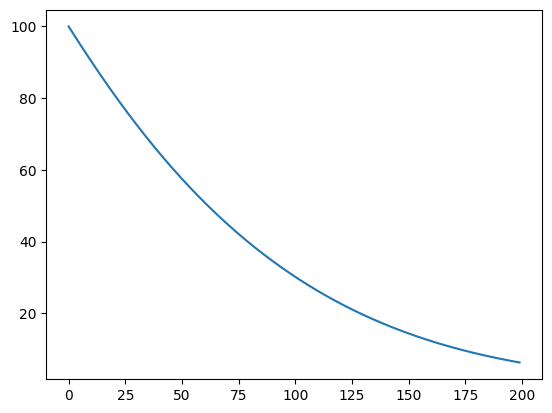

In [21]:
df = clerk.load_logs_to_pandas(tag='loss_log')
plt.plot(df['loss'])

If we want to continue the training process, we can use the Clerk’s resume functionality.
This is done by configuring the Clerk with `begin(resume=True)`.
When resuming, the parameters of the objects previously specified with `set_checkpoint_targets` will be restored from the checkpoint with the highest index.

In [22]:
with clerk.begin(resume=True):  # Enable Clerk's writing mode and resume from the latest checkpoint
    for epoch in range(10):
        for batch in range(20):
            
            loss = model()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            clerk.write_log(
                'loss_log',
                {
                    'loss': loss.item(),
                    'x': model.a.item(),
                    'batch': batch,
                    'epoch': epoch
                }
            )

        clerk.write_checkpoint(metadata={'epoch': epoch})

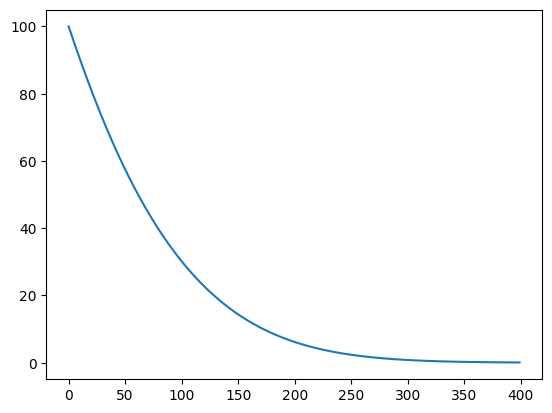

In [23]:
df = clerk.load_logs_to_pandas(tag='loss_log')
plt.plot(df['loss'])

You can see, that the learning continued for 200 steps more.

Another feature of the clerk is that during inference, we can load a specific checkpoint and use the stored model parameters for predictions.

In [24]:
# Initialize a new model for inference
model_inference = MyNet()

# Create a new Clerk instance to demonstrate checkpoint loading
clerk = Clerk('experiment_example')

# Load the experiment conditions
conditions = clerk.load_conditions()

# Load checkpoint with index 9 and apply the weights to the model only.
# If no targets are specified, the ones set with `set_checkpoint_targets`
# for the new Clerk instance will be used by default, if any.
metadata = clerk.load_checkpoint(9, targets={
    'model': model_inference
})

# Display loaded conditions and metadata
print('conditions', conditions)
print('metadata:', metadata)

conditions {'date': '23/01', 'description': 'Example model', 'some_parameters': [1.0, 123, '1']}
metadata: {'epoch': 9}


Clerk provides an automatic backup feature, ensuring that if an exception occurs inside its context, the training state is saved.
This helps prevent data loss and allows resumption from the latest valid state.
To enable this feature, set the autosave_checkpoint flag to True:

In [ ]:
try:
    with clerk.begin(resume=True, autosave_checkpoint=True):
        for epoch in range(10):
            for batch in range(20):
                # Simulating an error
                raise RuntimeError
except:
    pass

To remove all backup checkpoints, use:

In [26]:
clerk.clean_backup_checkpoints()